### 2 $\alpha$ model
- Estimate learning parameter for chosen and unchosen arms/choices. If the animals are learning, then one should expect that the chosen and unchosen arm will have postive and negative $\alpha$ respectively.

In [ ]:
import numpy as np
import pandas as pd
from banditpy.analyses import QlearningEstimator
import mab_subjects

exps = mab_subjects.struc.allsess + mab_subjects.unstruc.allsess

params_df = []

for i, exp in enumerate(exps):
    mab = exp.mab.keep_by_trials(min_trials=100, clip_max=100)
    print(exp.sub_name)
    qlearn = QlearningEstimator(mab)
    qlearn.fit(
        x0=None,
        bounds=np.array([(-1, 1), (-1, 1), (0.005, 20)]),
        method="diff_evolution",
        n_opts=5,
        n_cpu=4,
    )

    qlearn.print_params()
    df = pd.DataFrame(
        {
            "name": exp.sub_name,
            "param": ["alpha_chosen", "alpha_unchosen", "beta"],
            "param_values": np.array([qlearn.alpha_c, qlearn.alpha_u, qlearn.beta]),
            "grp": "struc" if mab.is_structured else "unstruc",
        }
    )
    params_df.append(df)

params_df = pd.concat(params_df, ignore_index=True)
mab_subjects.GroupData().save(params_df, "qlearning_2alpha_params_anirudh")

In [ ]:
from neuropy import plotting
import pandas as pd
import seaborn as sns

params_df = mab_subjects.GroupData().qlearning_2alpha_params_anirudh

fig = plotting.Fig(1, 2, size=(4, 3), num=1)
ax1 = fig.subplot(fig.gs[0])
ax2 = fig.subplot(fig.gs[1])

plot_kw = dict(x="param", y="param_values", hue="grp")
bar_kw = dict(
    errorbar="se",
    palette="dark:black",
    linestyle="none",
    alpha=0.5,
    dodge=0.4,
    zorder=1,
    marker=".",
    markersize=10,
    markeredgewidth=0,
    err_kws={"linewidth": 1},
)
strip_kw = dict(palette="husl", alpha=0.5, dodge=True, zorder=2)


alpha_df = params_df[params_df["param"] != "beta"]
sns.pointplot(alpha_df, ax=ax1, **plot_kw, **bar_kw)
sns.stripplot(alpha_df, ax=ax1, **plot_kw, **strip_kw)

beta_df = params_df[params_df["param"] == "beta"]
sns.pointplot(beta_df, ax=ax2, **plot_kw, **bar_kw)
sns.stripplot(beta_df, ax=ax2, **plot_kw, **strip_kw)

ax1.set_ylabel("Estimated alpha values")
ax2.set_ylabel("Estimated beta values")
fig.fig.suptitle("Q-learning in two-armed bandit task")

### 2 $\alpha$ + H model 
- When we estimated alpha parameters for chosen and unchosen choices, we found that unstructured env had higher alpha values for chosen arms compared to structured env. So we asked if 'persevrance' for arms/choices is making alpha_chosen higher for unstructured environment.
- 20-11-2025: Qlearning fit was carried out on server
- 30-12-2025: Code updated to policy based coding


In [ ]:
import numpy as np
import pandas as pd
from banditpy.models import DecisionModel
from banditpy.models.policy import QlearnH2Arm
import mab_subjects

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_unstruc.allsess

params_df = []

for i, exp in enumerate(exps[:1]):
    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    print(exp.sub_name)

    policy = QlearnH2Arm()
    # --- Use this to set custom bounds ---
    # policy.set_bounds(
    #     alpha_c=(-1, 1),
    #     alpha_u=(-1, 1),
    #     alpha_h=(0, 1),
    #     scaler=(1, 10),
    #     beta=(0.005, 20),
    # )

    model = DecisionModel(task, policy=QlearnH2Arm())
    model.fit(method="lbfgs", n_jobs=1, n_starts=1, progress=True)
    model.describe()
    model
    df = pd.DataFrame(
        {
            "name": exp.sub_name,
            "param": list(model.params.keys()),
            "param_values": list(model.params.values()),
            "grp": exp.group_tag,
        }
    )
    params_df.append(df)

params_df = pd.concat(params_df, ignore_index=True)
# mab_subjects.GroupData().save(params_df, "qlearn_2alphaH")

c:\Users\asheshlab\miniconda3\envs\data_analysis\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Users\asheshlab\miniconda3\envs\data_analysis\Lib\site-packages\scipy\_lib\_util.py:352: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
C:\Users\asheshlab\Documents\Codes\StatPlotAnnot\statplotannot\stats\bootstrap_tests.py:71: RuntimeWarning: invalid value encountered in scalar divide
  statistic = np.abs(sample1.mean() - sample2.mean()) / np.sqrt(
c:\Users\asheshlab\miniconda3\envs\data_analysis\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Users\asheshlab\miniconda3\envs\data_analysis\Lib\site-packages\scipy\_lib\_util.py:352: Degenerate

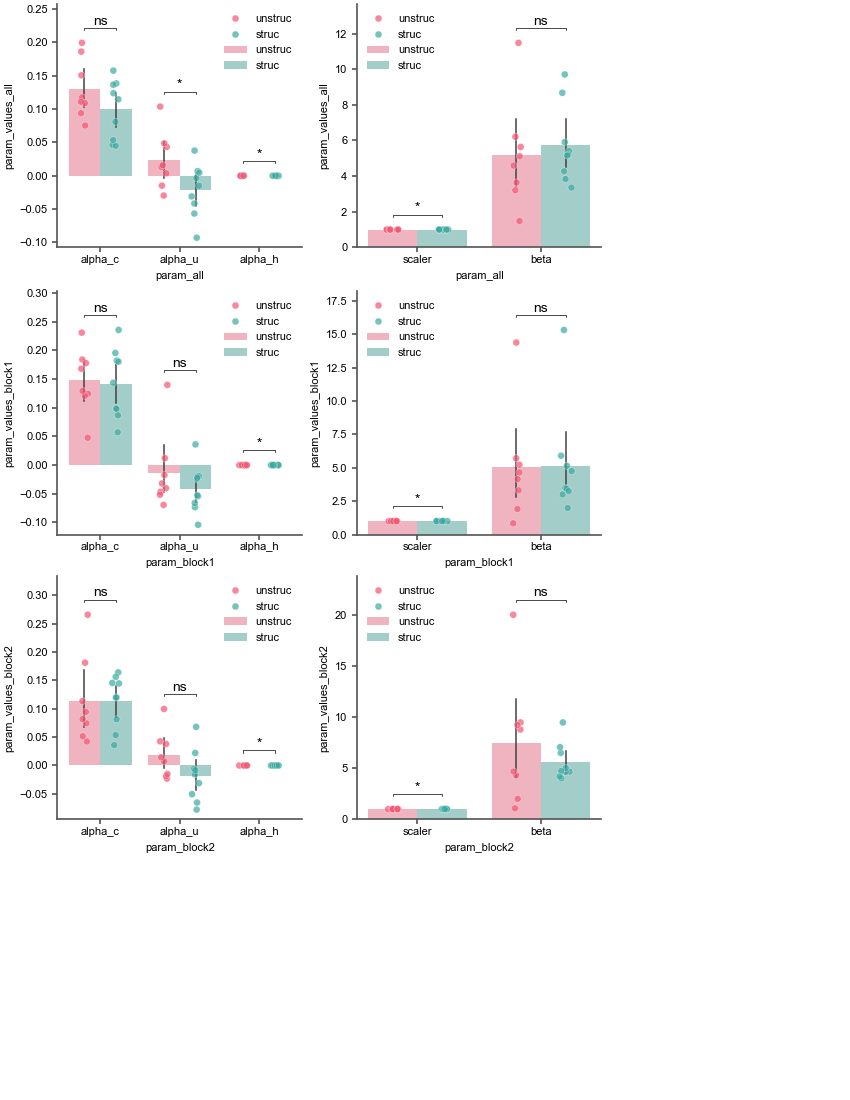

In [73]:
import mab_subjects
from neuropy import plotting
from statplotannot.plots import SeabornPlotter
from mab_colors import Palette2Arm


df = mab_subjects.GroupData().qlearnH.latest
fig = plotting.Fig(4, 3)
palette = Palette2Arm().as_dict()
strip_kw = dict(size=5, linewidth=0.3, alpha=0.7, palette=palette)
bar_kw = dict(alpha=0.5, palette=palette)

for i, block in enumerate(["all", "block1", "block2"]):
    alpha_df = df[df[f"param_{block}"].isin(["alpha_c", "alpha_u", "alpha_h"])]
    beta_df = df[df[f"param_{block}"].isin(["scaler", "beta"])]

    plot_kw = dict(
        x=f"param_{block}",
        y=f"param_values_{block}",
        hue="grp",
        hue_order=["unstruc", "struc"],
    )

    ax1 = fig.subplot(fig.gs[i, 0])
    SeabornPlotter(data=alpha_df, ax=ax1, **plot_kw).stripplot(**strip_kw).barplot(
        **bar_kw
    ).bootstrap_test()

    ax2 = fig.subplot(fig.gs[i, 1])
    SeabornPlotter(data=beta_df, ax=ax2, **plot_kw).stripplot(**strip_kw).barplot(
        **bar_kw
    ).bootstrap_test()

### Lesion Data: Plotting datasets (server generated)

In [ ]:
from neuropy import plotting
import pandas as pd
from pathlib import Path
import seaborn as sns
from mab_colors import colors_2arm
from statplotannot.plots import fix_legend, SeabornPlotter
import mab_subjects

fp = Path(
    "C:/Users/asheshlab/OneDrive/academia/analyses/adlab/results/qlearn_2alphaH_fit_1stBlock_24112025_154819.csv"
)
data = pd.read_csv(fp)
data = data[data["lesion"].isin(["pre_lesion", "naive_lesion_OFC"])]
# data = mab_subjects.GroupData().qlearn_2alphaH_fit_1stBlock25trials_26112025_112008
# data = data[~data["lesion"].isin(["post_lesion_OFC"])]


data1 = data[data["param"].isin(["alpha_chosen", "alpha_unchosen"])]
data1["grp_new"] = data1["grp"] + "_" + data1["lesion"]

data2 = data[data["param"].isin(["persev"])]
data2["grp_new"] = data2["grp"] + "_" + data2["lesion"]

data3 = data[data["param"].isin(["beta"])]
data3["grp_new"] = data3["grp"] + "_" + data3["lesion"]

fig = plotting.Fig(4, 8, num=2, fontsize=11)
fig.fig.suptitle("Q-learning parameters in two-armed bandit task")

hue_order = [
    "unstruc_pre_lesion",
    "unstruc_naive_lesion_OFC",
    "unstruc_post_lesion_OFC",
    "struc_pre_lesion",
    "struc_naive_lesion_OFC",
    "struc_post_lesion_OFC",
]
# hue_order = [
#     "unstruc_pre_lesion",
#     "unstruc_naive_lesion_OFC",
#     "struc_pre_lesion",
#     "struc_naive_lesion_OFC",
# ]
# palette = ["#ed1212", "#f57979", "#faa9a9", "#1342ed", "#80a6f7", "#b0b4fc"]
# palette = ["#ed1212", "#1342ed"]
palette = colors_2arm()

axs = [fig.subplot(fig.gs[0, :2]), fig.subplot(fig.gs[2]), fig.subplot(fig.gs[3])]

for i, df in enumerate([data1, data2, data3]):
    ax = axs[i]

    SeabornPlotter(
        data=df,
        x="param",
        y="param_values",
        hue="grp",
        hue_order=hue_order,
        ax=ax,
    ).barplot(
        palette=palette,
        linestyle="none",
        alpha=0.8,
        dodge=0.4,
        zorder=1,
        # width=width,
        err_kws={"linewidth": 1},
        errorbar="se",
    ).bootstrap_test()

    ax.set_ylabel("Parameter value")
    ax.set_xlabel("")
    # ax.tick_params(axis="x", rotation=30)
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        label.set_rotation_mode("anchor")
        label.set_horizontalalignment("right")

    if i == 0:
        fix_legend(ax, only_labels=False)
        ax.set_xlim(-1, 2)
        ax.axhline(0, ls="--", color="gray", zorder=0, lw=0.8)
    else:
        ax.legend_.remove()
        # ax.set_xlim(-0.5, 0.5)
        ax.set_xlim(-0.75, 1)


figpath = Path("C:/Users/asheshlab/OneDrive/academia/analyses/adlab/figures")
# fig.savefig(figpath / "qlearning_2alphaH_params", format="svg")

### Simulate choices/performance using estimated params from $2\alpha+H$ model
- reproduce performance curves after predicting choices based on estimated params

In [57]:
mab_subjects.GroupData().qlearnH.latest

,name,trial_id,perf,perf_sim,grp
0,BGM0,1,0.514451,0.504817,unstruc
1,BGM0,2,0.518304,0.535645,unstruc
2,BGM0,3,0.520231,0.558767,unstruc
3,BGM0,4,0.526012,0.579961,unstruc
4,BGM0,5,0.533719,0.583815,unstruc
...,...,...,...,...,...
1695,Xavi,96,0.703640,0.842288,struc
1696,Xavi,97,0.703640,0.852686,struc
1697,Xavi,98,0.698440,0.835355,struc
1698,Xavi,99,0.700173,0.842288,struc


In [ ]:
import numpy as np
import pandas as pd
from banditpy.models import DecisionModel
from banditpy.models.policy import QlearnH2Arm
import mab_subjects
from banditpy.core import mab

exps = mab_subjects.mostly_unstruc.allsess + mab_subjects.mostly_struc.allsess
est_params_df = mab_subjects.GroupData().qlearnH.latest

perf_df = []

for i, exp in enumerate(exps):
    name = exp.sub_name
    print(name)

    task = exp.b2a.filter_by_trials(min_trials=100, clip_max=100)
    task.auto_block_window_ids()

    mask_block1 = task.block_window_ids == 1
    task_block1 = task._filtered(mask_block1)

    mask_block2 = task.block_window_ids == 2
    task_block2 = task._filtered(mask_block2)

    policy = QlearnH2Arm()
    param_names = est_params_df[est_params_df["name"] == name]["param_all"]
    param_values = est_params_df[est_params_df["name"] == name]["param_values_all"]
    param_dict = dict(zip(param_names, param_values))

    model = DecisionModel(task, policy=policy)
    model.params = param_dict
    task_sim = model.simulate_posterior_predictive()

    sub_df = pd.DataFrame(
        {
            "name": exp.sub_name,
            "trial_id": np.arange(100) + 1,
            "perf": task.get_optimal_choice_probability(),
            "perf_sim": task_sim.get_optimal_choice_probability(),
            "grp": exp.group_tag,
        }
    )
    perf_df.append(sub_df)

perf_df = pd.concat(perf_df, ignore_index=True)

mab_subjects.GroupData().save(perf_df, "qlearnH_sim")

BGM0
BGF1
BGF2
BGF3
BGM5
Messi
Neymar
Son
BGM1
BGF0
BGM3
BGM4
BGF4
Gavi
Haaland
Pedri
Xavi
[GroupData] Saved: qlearnH_sim_20260101_174419.npy


'qlearnH_sim_20260101_174419.npy'

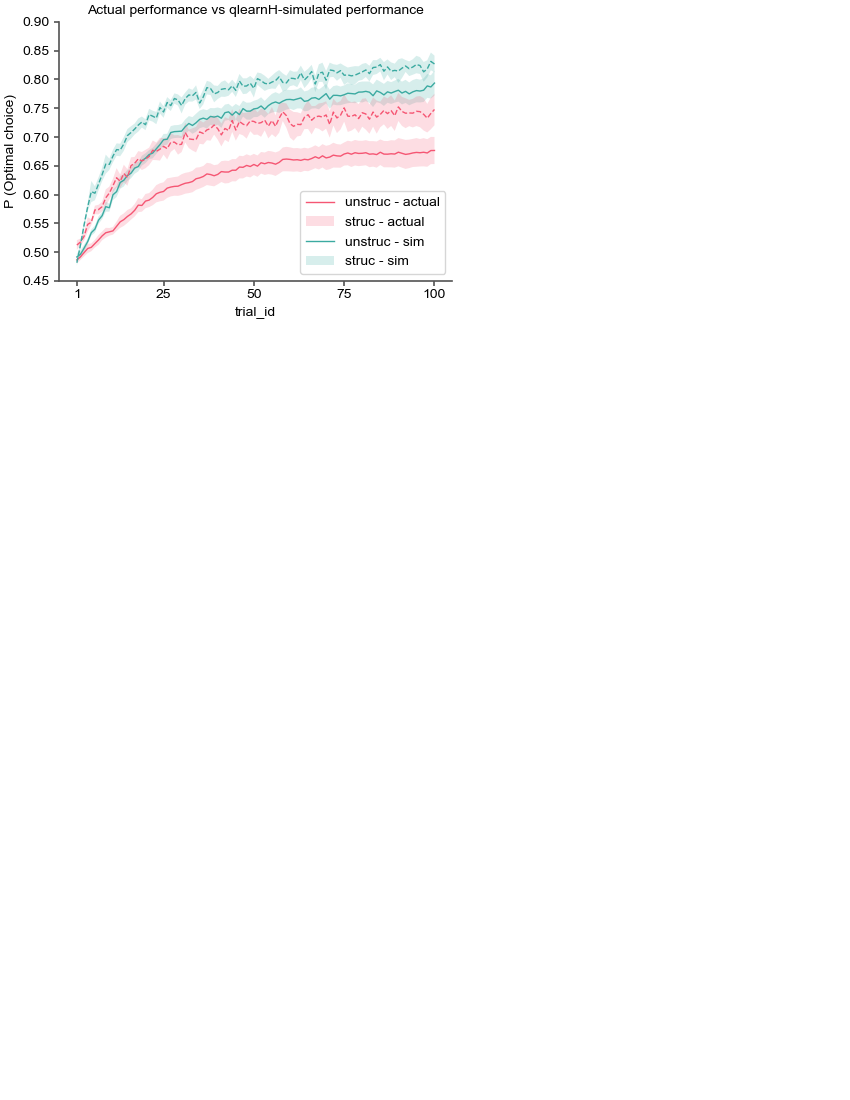

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
from mab_colors import Palette2Arm
import numpy as np

fig = plotting.Fig(4, 2, size=(8.5, 11), fontsize=10)

df = mab_subjects.GroupData().qlearnH_sim.latest


ax = fig.subplot(fig.gs[0])
hue_order = ["unstruc", "struc"]
plot_kw = dict(
    data=df,
    x="trial_id",
    hue="grp",
    hue_order=hue_order,
    palette=Palette2Arm().as_dict(),
    linewidth=1,
    errorbar="se",
    err_kws=dict(edgecolor="none"),
    ax=ax,
)
sns.lineplot(y="perf", linestyle="solid", **plot_kw)
sns.lineplot(y="perf_sim", linestyle="dashed", **plot_kw)

# ax.grid(True)
# ax.legend(['s','b','sd','sd'])
ax.set_title("Actual performance vs qlearnH-simulated performance")
ax.set_ylabel("P (Optimal choice)")
ax.set_ylim(0.45, 0.9)
ax.set_xticks([1, 25, 50, 75, 100])
# ax.get_legend().remove()
# ax.legend(['a','b','c','d'])

ax.legend(["unstruc - actual", "struc - actual", "unstruc - sim", "struc - sim"])

### Params estimation for "Structured" sessions in Unstructured Environment.
- Basically select sessions where the probabilities sum up to 1 i.e, correlated sessions withing Unstructured environment. Estimate various params like alpha_chosen, alpha_unchosen etc. on these sessions and compare these with Structured Environment.

In [ ]:
import numpy as np
import pandas as pd
from banditpy.analyses import QlearningEstimator
import mab_subjects

exps = mab_subjects.unstruc.allsess

params_df = []

for i, exp in enumerate(exps):
    mab = exp.mab.keep_by_trials(min_trials=100, clip_max=100)
    print(exp.sub_name)
    session_prob_sum = mab.probs[mab.is_session_start.astype(bool)].sum(axis=1)
    good_sessions = mab.sessions[session_prob_sum == 1]
    assert np.all(good_sessions)

    mab = mab.keep_sessions_by_id(good_sessions)

    qlearn = QlearningEstimator(mab, model="persev")
    qlearn.fit(
        x0=None,
        bounds=np.array([(-1, 1), (-1, 1), (0, 1), (1, 10), (0.005, 20)]),
        method="diff_evolution",
        n_opts=5,
        n_cpu=4,
    )

    qlearn.print_params()
    df = pd.DataFrame(
        {
            "name": exp.sub_name,
            "param": ["alpha_chosen", "alpha_unchosen", "persev", "scaler", "beta"],
            "param_values": qlearn.estimated_params,
            "grp": "struc" if mab.is_structured else "unstruc",
        }
    )
    params_df.append(df)

params_df = pd.concat(params_df, ignore_index=True)
mab_subjects.GroupData().save(
    params_df, "qlearning_2alpha_persev_correlated_within_unstructured_anirudh"
)

In [ ]:
from neuropy import plotting
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
from statplot_utils import stat_kw

df1 = mab_subjects.GroupData().qlearning_2alpha_persev_anirudh
df2 = (
    mab_subjects.GroupData().qlearning_2alpha_persev_correlated_within_unstructured_anirudh
)
df2["grp"] = "struc_in_unstruc"
params_df = pd.concat([df1, df2], ignore_index=True)

fig = plotting.Fig(1, 3, size=(6, 4), num=1)
ax1 = fig.subplot(fig.gs[0])
ax2 = fig.subplot(fig.gs[1])

plot_kw = dict(
    x="param",
    y="param_values",
    hue="grp",
    hue_order=["unstruc", "struc", "struc_in_unstruc"],
)
bar_kw = dict(
    errorbar="se",
    palette="dark:black",
    linestyle="none",
    alpha=0.5,
    dodge=0.4,
    zorder=1,
    marker=".",
    markersize=10,
    markeredgewidth=0,
    err_kws={"linewidth": 1},
)
strip_kw = dict(palette="husl", alpha=0.5, dodge=True, zorder=2)

indx_bool = params_df["param"].isin(["scaler", "beta"])

alpha_df = params_df[~indx_bool]
sns.pointplot(alpha_df, ax=ax1, **plot_kw, **bar_kw)
sns.stripplot(alpha_df, ax=ax1, **plot_kw, **strip_kw)

# orders = ["alpha_chosen", "alpha_unchosen", "persev"]
# pairs = [((_, "unstruc"), (_, "struc")) for _ in orders]
# annotator = Annotator(pairs=pairs, data=alpha_df, ax=ax1, **plot_kw, order=orders)
# annotator.configure(test="t-test_ind", **stat_kw, color="k", verbose=True)
# annotator.apply_and_annotate()
# annotator.reset_configuration()


beta_df = params_df[indx_bool]
sns.pointplot(beta_df, ax=ax2, **plot_kw, **bar_kw)
sns.stripplot(beta_df, ax=ax2, **plot_kw, **strip_kw)

# orders = ["scaler", "beta"]
# pairs = [((_, "unstruc"), (_, "struc")) for _ in orders]
# annotator = Annotator(pairs=pairs, data=beta_df, ax=ax2, **plot_kw, order=orders)
# annotator.configure(test="t-test_ind", **stat_kw, color="k", verbose=True)
# annotator.apply_and_annotate()
# annotator.reset_configuration()


ax1.axhline(0, ls="--", color="gray", zorder=0, lw=0.8)
ax2.set_xlim(-1, 2)
ax2.set_ylim(1, 15)

ax1.tick_params(axis="x", rotation=30)
ax2.tick_params(axis="x", rotation=30)

ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.legend_.remove()
ax2.legend_.remove()
ax1.set_ylabel("Estimated alpha values")
ax2.set_ylabel("Estimated beta values")
fig.fig.suptitle("Q-learning in two-armed bandit task")

### Fit Qlerning params from one env to other.
- Take average of parameters like alpha_chosen, persev etc. from structured environment and predict actions in unstructured env. Following this calculate performance and compare that to actual performance. 

In [ ]:
import numpy as np
import pandas as pd
from banditpy.analyses import QlearningEstimator
import mab_subjects
from banditpy.core import TwoArmedBandit

exps = mab_subjects.struc.first_exposure + mab_subjects.unstruc.first_exposure

est_params_df = mab_subjects.GroupData().qlearning_2alpha_persev
first_exposure_bool = est_params_df["name"].str.contains("Exp1")
est_params_df = est_params_df[first_exposure_bool]
mean_params_df = (
    est_params_df.groupby(["grp", "param"]).mean(numeric_only=True).reset_index()
)


mean_struc = mean_params_df[mean_params_df["grp"] == "struc"]
mean_unstruc = mean_params_df[mean_params_df["grp"] == "unstruc"]
param_order = ["alpha_chosen", "alpha_unchosen", "persev", "scaler", "beta"]

perf_df = []

for i, exp in enumerate(exps):
    mab = exp.mab.filter_by_trials(min_trials=100, clip_max=100)
    name = exp.sub_name
    print(name)

    qlearn = QlearningEstimator(mab, model="persev")

    if mab.is_structured:
        df = mean_unstruc.copy()
    else:
        df = mean_struc.copy()

    params = np.array(
        [
            df.loc[df["param"] == "alpha_chosen", "param_values"].to_numpy(),
            df.loc[df["param"] == "alpha_unchosen", "param_values"].to_numpy(),
            df.loc[df["param"] == "persev", "param_values"].to_numpy(),
            df.loc[df["param"] == "scaler", "param_values"].to_numpy(),
            df.loc[df["param"] == "beta", "param_values"].to_numpy(),
        ]
    )
    predicted_choices = qlearn.predict_choices(params=params, deterministic=False)

    new_mab = TwoArmedBandit(
        probs=mab.probs,
        choices=predicted_choices,
        rewards=mab.rewards,
        session_ids=mab.session_ids,
        starts=mab.starts,
        stops=mab.stops,
        datetime=mab.datetime,
    )

    sub_df = pd.DataFrame(
        {
            "name": exp.sub_name,
            "trial_id": np.arange(100) + 1,
            "perf": mab.get_performance(),
            "perf_new": new_mab.get_performance(),
            "grp": "struc" if mab.is_structured else "unstruc",
        }
    )
    perf_df.append(sub_df)

perf_df = pd.concat(perf_df, ignore_index=True)

mab_subjects.GroupData().save(perf_df, "perf_qlearning_switch_params")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statannotations.Annotator import Annotator
from statplot_utils import stat_kw

fig = plotting.Fig(8, 4, size=(8.5, 11), num=1)

grpdata = mab_subjects.GroupData()
df = grpdata.perf_qlearning_switch_params


ax = fig.subplot(fig.gs[0])
# ax.axhline(0, color="gray", lw=0.8, zorder=0)
hue_order = ["unstruc", "struc"]
plot_kw = dict(data=df, x="trial_id", y="perf", hue="grp", hue_order=hue_order, ax=ax)
sns.lineplot(
    palette=["#f77189", "#36ada4"],
    lw=1,
    # edgecolor="white",
    # facecolor=(0, 0, 0, 0),
    # alpha=0.4,
    err_kws=dict(edgecolor="none"),
    errorbar="se",
    **plot_kw,
)
plot_kw = dict(
    data=df, x="trial_id", y="perf_new", hue="grp", hue_order=hue_order, ax=ax
)
sns.lineplot(
    palette=["#f77189", "#36ada4"],
    linestyle="--",
    lw=1,
    # facecolor=(0, 0, 0, 0),
    # alpha=0.4,
    err_kws=dict(edgecolor="none"),
    errorbar="se",
    **plot_kw,
)

# orders = ["unstruc", "struc"]
# pairs = [(("unstruc"), ("struc"))]
# annotator = Annotator(pairs=pairs, order=orders, **plot_kw)
# annotator.configure(test="Kruskal", **stat_kw, color="k", verbose=True)
# annotator.apply_and_annotate()
# annotator.reset_configuration()
# ax.grid(True)
ax.set_title("Performance with swapped Params\n(First exp.)")
ax.set_ylabel("Performance")
ax.set_ylim(0.45, 1)
ax.set_xticks([1, 50, 100])
ax.get_legend().remove()

### Simulate switching prob. (Beron 2022 style) using estimated params of $2\alpha+H$ model

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.core import TwoArmedBandit
from bandit_utils import choices_to_strseq_Beron2022

exps = mab_subjects.unstruc.first_exposure + mab_subjects.struc.first_exposure
est_params_df = mab_subjects.GroupData().qlearning_2alpha_persev


swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    mab = exp.mab.filter_by_trials(min_trials=100, clip_max=100)
    switch_prob, seq = mab.get_switch_prob_by_history(3)
    switch_prob, seq = choices_to_strseq_Beron2022(switch_prob, seq)

    # ----- simulated choices-------

    qlearn = QlearningEstimator(mab, model="persev")

    sim_df = est_params_df[est_params_df["name"] == name]
    params = np.array(
        [
            sim_df.loc[sim_df["param"] == "alpha_chosen", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "alpha_unchosen", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "persev", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "scaler", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "beta", "param_values"].to_numpy(),
        ]
    )
    predicted_choices = qlearn.predict_choices(params=params, deterministic=False)

    sim_mab = TwoArmedBandit(
        probs=mab.probs,
        choices=predicted_choices,
        rewards=mab.rewards,
        session_ids=mab.session_ids,
        starts=mab.starts,
        stops=mab.stops,
        datetime=mab.datetime,
    )
    sim_switch_prob, sim_seq = sim_mab.get_switch_prob_by_history(n_past=3)
    sim_switch_prob, sim_seq = choices_to_strseq_Beron2022(sim_switch_prob, sim_seq)

    assert np.all(np.equal(seq, sim_seq)), "sequences differ"

    df = pd.DataFrame(
        {
            "switch_prob": switch_prob,
            "sim_switch_prob": sim_switch_prob,
            "seq": seq,
            "name": exp.sub_name,
            "grp": "struc" if mab.is_structured else "unstruc",
        }
    )
    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(swp_df, "switch_prob_seq_with_simulated_FE")

In [ ]:
from neuropy import plotting
import mab_subjects
import numpy as np
from statplotannot.plots import SeabornPlotter


df = mab_subjects.GroupData().switch_prob_seq_with_simulated_FE

fig = plotting.Fig(8, 3, size=(8.5, 11), num=1)

for i, col in enumerate(["switch_prob", "sim_switch_prob"]):

    ax = fig.subplot(fig.gs[i, :2])
    SeabornPlotter(
        data=df,
        x="seq",
        y=col,
        hue="grp",
        hue_order=["unstruc", "struc"],
        ax=ax,
    ).barplot(dodge=False, palette="husl", alpha=0.5, err_kws={"lw": 1}).annot(
        test_name="Kruskal"
    )

    if i == 0:
        title = "Switch probability\n(First experience)"
    elif i == 1:
        title = "Simulated switch probability\n(First experience)"

    ax.set_title(title)
    ax.tick_params("x", rotation=90)
    ax.set_ylabel("P(Switch)")
    ax.set_xlabel("History sequence")
    ax.set_ylim(0, 0.75)
    ax.get_legend().remove()

### Swap Params: Simulate switching prob. (Beron 2022 style) using another environments estimated params of $2\alpha+H$ model

In [ ]:
import numpy as np
import pandas as pd
import mab_subjects
from banditpy.core import TwoArmedBandit
from bandit_utils import choices_to_strseq_Beron2022

exps = mab_subjects.unstruc.first_exposure + mab_subjects.struc.first_exposure
est_params_df = mab_subjects.GroupData().qlearning_2alpha_persev
first_exposure_bool = est_params_df["name"].str.contains("Exp1")
est_params_df = est_params_df[first_exposure_bool]
mean_params_df = (
    est_params_df.groupby(["grp", "param"]).mean(numeric_only=True).reset_index()
)


mean_struc = mean_params_df[mean_params_df["grp"] == "struc"]
mean_unstruc = mean_params_df[mean_params_df["grp"] == "unstruc"]
param_order = ["alpha_chosen", "alpha_unchosen", "persev", "scaler", "beta"]


swp_df = []

for i, exp in enumerate(exps):
    print(exp.sub_name)
    mab = exp.mab.filter_by_trials(min_trials=100, clip_max=100)
    switch_prob, seq = mab.get_switch_prob_by_history(3)
    switch_prob, seq = choices_to_strseq_Beron2022(switch_prob, seq)

    # ----- simulated choices-------

    qlearn = QlearningEstimator(mab, model="persev")

    if mab.is_structured:
        sim_df = mean_unstruc.copy()
    else:
        sim_df = mean_struc.copy()

    params = np.array(
        [
            sim_df.loc[sim_df["param"] == "alpha_chosen", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "alpha_unchosen", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "persev", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "scaler", "param_values"].to_numpy(),
            sim_df.loc[sim_df["param"] == "beta", "param_values"].to_numpy(),
        ]
    )
    predicted_choices = qlearn.predict_choices(params=params, deterministic=False)

    sim_mab = TwoArmedBandit(
        probs=mab.probs,
        choices=predicted_choices,
        rewards=mab.rewards,
        session_ids=mab.session_ids,
        starts=mab.starts,
        stops=mab.stops,
        datetime=mab.datetime,
    )
    sim_switch_prob, sim_seq = sim_mab.get_switch_prob_by_history(n_past=3)
    sim_switch_prob, sim_seq = choices_to_strseq_Beron2022(sim_switch_prob, sim_seq)

    assert np.all(np.equal(seq, sim_seq)), "sequences differ"

    df = pd.DataFrame(
        {
            "switch_prob": switch_prob,
            "sim_switch_prob": sim_switch_prob,
            "seq": seq,
            "name": exp.sub_name,
            "grp": "struc" if mab.is_structured else "unstruc",
        }
    )
    swp_df.append(df)

swp_df = pd.concat(swp_df, ignore_index=True)
mab_subjects.GroupData().save(
    swp_df, "switch_prob_seq_with_simulated_switched_params_FE"
)

In [ ]:
from neuropy import plotting
import mab_subjects
import numpy as np
from statplotannot.plots import SeabornPlotter


df = mab_subjects.GroupData().switch_prob_seq_with_simulated_switched_params_FE

fig = plotting.Fig(8, 3, size=(8.5, 11), num=1)

for i, col in enumerate(["switch_prob", "sim_switch_prob"]):

    ax = fig.subplot(fig.gs[i, :2])
    SeabornPlotter(
        data=df,
        x="seq",
        y=col,
        hue="grp",
        hue_order=["unstruc", "struc"],
        ax=ax,
    ).barplot(dodge=False, palette="husl", alpha=0.5, err_kws={"lw": 1}).annot(
        test_name="Kruskal"
    )

    if i == 0:
        title = "Switch probability\n(First experience)"
    elif i == 1:
        title = "Simulated switch probability with swapped params \n(First experience)"

    ax.set_title(title)
    ax.tick_params("x", rotation=90)
    ax.set_ylabel("P(Switch)")
    ax.set_xlabel("History sequence")
    ax.set_ylim(0, 0.75)
    ax.get_legend().remove()

### Plot: Simulated and Swapped params performance

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from neuropy import plotting
import mab_subjects
import numpy as np
from statannotations.Annotator import Annotator


fig = plotting.Fig(7, 4, size=(8.5, 11), num=2)

df1 = mab_subjects.GroupData().perf_qlearning_switch_params
df2 = mab_subjects.GroupData().perf_qlearning_assess_params
df = pd.merge(df1, df2, on=["name", "trial_id", "grp"])


colors = ["#f55673", "#3d9991"]
# colors = ["#E89317", "#3980ea"]
for i, env in enumerate(["unstruc", "struc"]):

    ax = fig.subplot(fig.gs[i])

    plot_kw = dict(data=df[df["grp"] == env], x="trial_id", y="perf_new_x", ax=ax)
    sns.lineplot(
        color=colors[i],
        linewidth=1,
        err_kws=dict(edgecolor="none"),
        errorbar="se",
        **plot_kw,
        label="swapped_param",
    )

    plot_kw = dict(data=df[df["grp"] == env], x="trial_id", y="perf_new_y", ax=ax)
    sns.lineplot(
        color=colors[i],
        linestyle="--",
        linewidth=1,
        err_kws=dict(edgecolor="none"),
        errorbar="se",
        **plot_kw,
        label="simulated",
    )

    ax.set_title("Performance\n(First experience)")
    ax.set_ylabel("Performance")
    ax.set_ylim(0.45, 0.9)
    ax.set_xticks([1, 50, 100])
    # ax.get_legend().remove()
    ax.legend()

### Correlate learning rate with performance

In [ ]:
import matplotlib.pyplot as plt
from neuropy import plotting
import numpy as np
import mab_subjects
from scipy import stats
from scipy.ndimage import gaussian_filter1d


fig = plotting.Fig(7, 4, size=(8.5, 11), num=2)

df1 = mab_subjects.GroupData().perf_difficulty_level
df1 = df1[df1["name"].str.contains("Exp1")]
# 0022ff
df2 = mab_subjects.GroupData().qlearning_2alpha_persev
df2 = df2[df2["name"].str.contains("Exp1")]

names = df1["name"].unique()
delta_perf = []
alpha = []

for i, name in enumerate(names):
    df1_sub = df1[df1["name"] == name]
    perf = df1_sub["perf"].to_numpy()
    perf = gaussian_filter1d(perf, sigma=2)
    delta_perf.append(perf[-1] - perf[0])
    df2_sub = df2[df2["name"] == name]
    alpha.append(
        df2_sub[df2_sub["param"] == "alpha_chosen"]["param_values"].to_numpy()[0]
    )
linfit = stats.linregress(alpha, delta_perf, alternative="less")

ax = fig.subplot(fig.gs[0])
ax.scatter(alpha, delta_perf, color="#0022ff", s=20, alpha=0.5)
ax.axline((0, linfit.intercept), slope=linfit.slope, color="r", linestyle="--", lw=1)
# ax.set_ylim(0.05, 0.45)
# ax.set_xlim(0, 0.2)
ax.set_xlabel("Alpha chosen")
ax.set_ylabel(r"$\Delta$ performance")
ax.set_title(
    f"Performance change with alpha chosen \n r = {linfit.rvalue:.2f}, p = {linfit.pvalue:.2e}\n(FE)"
)

### Relating learning rate with inverse temperature

In [ ]:
import matplotlib.pyplot as plt
from neuropy import plotting
import numpy as np
import mab_subjects
from scipy import stats

fig = plotting.Fig(7, 4, size=(8.5, 11), num=2)

df1 = mab_subjects.GroupData().qlearning_2alpha_persev
df1 = df1[df1["name"].str.contains("Exp1")]

alpha = df1[df1["param"] == "alpha_chosen"]["param_values"].to_numpy()
beta = df1[df1["param"] == "beta"]["param_values"].to_numpy()

linfit = stats.linregress(alpha, beta, alternative="less")

ax = fig.subplot(fig.gs[0])
ax.scatter(alpha, beta, color="#0022ff", s=20, alpha=0.5)
ax.axline((0, linfit.intercept), slope=linfit.slope, color="r", linestyle="--", lw=1)
# ax.set_ylim(0.05, 0.45)
# ax.set_xlim(0, 0.2)
ax.set_xlabel("Alpha chosen")
ax.set_ylabel(r"$\beta$")
ax.set_title(
    f"Alpha and Beta relationship, \n r = {linfit.rvalue:.2f}, p = {linfit.pvalue:.2e}\n(FE)"
)

#### Impure qlearning fit (server generated)

In [ ]:
import numpy as np
from neuropy import plotting
import pandas as pd
from pathlib import Path
import seaborn as sns
from mab_colors import colors_2arm
from statplotannot.plots import fix_legend, SeabornPlotter
import mab_subjects

data = mab_subjects.GroupData().qlearn_2alphaH_fit_impure_29112025_191854
data = data.pivot(
    index=["name", "grp"], columns="param", values="param_values"
).reset_index()
# data["alpha_asym"] = np.abs(data["alpha_chosen"] - data["alpha_unchosen"]) / (
#     data["alpha_chosen"] + data["alpha_unchosen"]
# )
data["alpha_asym"] = data["alpha_chosen"] * data["alpha_unchosen"]


data = data.melt(
    id_vars=["name", "grp"],
    value_vars=[
        "alpha_chosen",
        "alpha_unchosen",
        "alpha_asym",
        "persev",
        "beta",
        "scaler",
    ],
    var_name="param",
    value_name="param_values",
)

df1 = data[data["param"].isin(["alpha_chosen", "alpha_unchosen"])]
df2 = data[data["param"].isin(["persev"])]
df3 = data[data["param"].isin(["beta"])]


fig = plotting.Fig(4, 5, num=2, fontsize=10)
fig.fig.suptitle("Q-learning parameters in two-armed bandit task")

hue_order = [
    "unstruc",
    "struc",
]
# palette = ["#ed1212", "#1342ed"]
palette = colors_2arm()


for i, df in enumerate([df1, df2, df3]):
    ax = fig.subplot(fig.gs[i + 1])

    sns.stripplot(
        data=df,
        x="param",
        y="param_values",
        hue="grp",
        hue_order=hue_order,
        palette=palette,
        dodge=True,
        alpha=0.7,
        edgecolor="white",
        linewidth=0.5,
        zorder=2,
        ax=ax,
    )
    SeabornPlotter(
        data=df,
        x="param",
        y="param_values",
        hue="grp",
        hue_order=hue_order,
        ax=ax,
    ).barplot(
        palette=palette,
        linestyle="none",
        alpha=0.6,
        dodge=0.4,
        zorder=1,
        # width=width,
        err_kws={"linewidth": 1},
        errorbar="se",
    ).bootstrap_test()
    #
    ax.set_ylabel("Parameter value")
    ax.set_xlabel("")
    # ax.tick_params(axis="x", rotation=30)
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_rotation_mode("anchor")
        label.set_horizontalalignment("right")

    ax.legend_.remove()

    if i > 0:
        ax.set_xlim(-1, 1)
# figpath = Path("C:/Users/asheshlab/OneDrive/academia/analyses/adlab/figures")
# # fig.savefig(figpath / "qlearning_2alphaH_params_lesion", format="svg")